# 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import ast
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans

## Load processed data

In [ ]:
purchase_df = pd.read_csv('../datasets/3_purchase_features.csv')
purchase_df.head()

,playerid,library,library_list,library_size,avg_purchase_price,price_coverage
0,76561198060698936,"[60, 1670, 3830, 1600, 2900, 2910, 2920, 4800,...","[60, 1670, 3830, 1600, 2900, 2910, 2920, 4800,...",3340,15.058132,0.929341
1,76561198287452552,"[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698...","[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698...",476,19.027540,0.930672
2,76561198040436563,"[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130...","[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130...",836,21.927873,0.888756
3,76561198042412488,"[300, 240, 220, 320, 360, 4300, 4800, 4000, 61...","[300, 240, 220, 320, 360, 4300, 4800, 4000, 61...",881,17.918178,0.884222
4,76561198119605821,"[47870, 108600, 550, 271590, 331470, 381210, 2...","[47870, 108600, 550, 271590, 331470, 381210, 2...",20,22.494500,1.000000


In [ ]:
games_price_df = pd.read_csv('../datasets/2_games_prices_merged.csv')
games_price_df.head()

,gameid,title,developers,publishers,genres,supported_languages,release_date,genres_cleaned,360 Video,Accounting,...,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing,release_age_days,base_price,price_volatility,avg_discount
0,3281560,Horror Game To Play With Friends! Playtest,NaN,NaN,NaN,NaN,2024-10-21,[],0,0,...,0,0,0,0,0,0,345,0.0,0.0,0.0
1,3280930,Eternals' Path Playtest,NaN,NaN,NaN,NaN,2024-10-17,[],0,0,...,0,0,0,0,0,0,349,0.0,0.0,0.0
2,3280770,ANGST: A TALE OF SURVIVAL - Singleplayer Playtest,NaN,NaN,NaN,NaN,2024-10-13,[],0,0,...,0,0,0,0,0,0,353,0.0,0.0,0.0
3,3279790,Montabi Playtest,NaN,NaN,NaN,NaN,2024-10-13,[],0,0,...,0,0,0,0,0,0,353,0.0,0.0,0.0
4,3278320,파이팅걸 유리 Playtest,NaN,NaN,NaN,NaN,2024-10-12,[],0,0,...,0,0,0,0,0,0,354,0.0,0.0,0.0


In [ ]:
sentiment_df = pd.read_csv('../datasets/sentiment_reviews_18oct.csv')
sentiment_df.head()

,reviewid,playerid,gameid,review,helpful,funny,awards,posted,language,sentiment_score
0,639544,76561198028706627,393380,---{ Graphics }---☐ You forget what reality is...,0,0,0,2025-01-03,en,5.000000
1,639547,76561198272817436,730,ONE OF THE GAMES I COME BACK TO,2,0,0,2020-01-23,en,3.049362
2,639571,76561198111259840,1476680,I love this game!Of course it is currently in ...,5,0,1,2022-09-23,en,4.779496
3,639583,76561198164012532,244210,only purchase if using a sim wheel setup with ...,0,0,0,2021-09-17,en,4.823064
4,639671,76561198979874677,739630,Fun game and the community is great ive made t...,2,0,0,2020-11-27,en,5.000000


# 2. Sentiment Data (Processing)


## 2.1 Duplicate Check

Initial check confirmed that there are no duplicate reviews, meaning no single player submitted more than one review for the same game.


In [5]:
# Count the number of reviews per player for each game
review_counts = sentiment_df.groupby(['playerid', 'gameid']).size().reset_index(name='num_reviews')

# Filter to find instances where a player has more than one review (duplicates)
multiple_reviews = review_counts[review_counts['num_reviews'] > 1]

if multiple_reviews.empty:
    print("No instances found where a player gave multiple reviews for the same game.")
else:
    print(multiple_reviews)

No instances found where a player gave multiple reviews for the same game.


## 2.2 Per-Game Aggregation

Two key metrics for every unique game was calculated:
- `avg_sentiment_score`
- `num_reviews` (number of reviews that contributed to the avg_sentiment_score)

`global_avg_sentiment` across all reviewed games was also calculated to be used for handling missing data.

In [6]:
avg_sentiment_df = sentiment_df.groupby('gameid').agg(
    avg_sentiment_score=('sentiment_score', 'mean'),
    num_reviews=('reviewid', 'count')
).reset_index()

# Global average sentiment for imputation
global_avg_sentiment = avg_sentiment_df['avg_sentiment_score'].mean()    
print(f"Global Average Sentiment Score: {global_avg_sentiment}")

Global Average Sentiment Score: 4.083917446310093


## 2.3 Imputation & Weighted Sentiment Feature
- Sentiment features were merged with the main game data (games_price_df).
- Games that with no reviews were handled by having:
    - `avg_sentiment_score` imputed with the global_avg_sentiment (4.08)
    - `num_reviews` imputed with 0

- To ensure reliability, the sentiment score was weighted by the volume of reviews (confidence), preventing games with minimal feedback from overly influencing the recommendation system:
    - `log_num_reviews` is given by a log-transformed review count ($\log(1 + \text{Num Reviews})$). 
    - `weighted_sentiment` is given by the product of the average sentiment score and the log-transformed review count ($\text{Avg Sentiment} \times \text{Confidence Factor}$).

In [7]:
# Merge with games_price_df
games_price_sentiment_df = pd.merge(
    games_price_df, 
    avg_sentiment_df, 
    on='gameid', 
    how='left'
)

# Count how many games are missing sentiment scores
missing_sentiment_count = games_price_sentiment_df['avg_sentiment_score'].isnull().sum()
print(f"Number of games missing sentiment scores: {missing_sentiment_count}")
print(f"Total number of games: {len(games_price_sentiment_df)}")

Number of games missing sentiment scores: 70115
Total number of games: 98248


In [8]:
# Impute missing sentiment scores with global average and num_reviews with 0
games_price_sentiment_df['avg_sentiment_score'] = games_price_sentiment_df['avg_sentiment_score'].fillna(global_avg_sentiment)
games_price_sentiment_df['num_reviews'] = games_price_sentiment_df['num_reviews'].fillna(0).astype(int)

# Create log(1 + num_reviews) feature
games_price_sentiment_df['log_num_reviews'] = np.log1p(games_price_sentiment_df['num_reviews'])

# Create weighted sentiment feature
games_price_sentiment_df['weighted_sentiment'] = (
    games_price_sentiment_df['avg_sentiment_score'] * games_price_sentiment_df['log_num_reviews']
)

games_price_sentiment_df.head()


,gameid,title,developers,publishers,genres,supported_languages,release_date,genres_cleaned,360 Video,Accounting,...,Violent,Web Publishing,release_age_days,base_price,price_volatility,avg_discount,avg_sentiment_score,num_reviews,log_num_reviews,weighted_sentiment
0,3281560,Horror Game To Play With Friends! Playtest,NaN,NaN,NaN,NaN,2024-10-21,[],0,0,...,0,0,345,0.0,0.0,0.0,4.083917,0,0.0,0.0
1,3280930,Eternals' Path Playtest,NaN,NaN,NaN,NaN,2024-10-17,[],0,0,...,0,0,349,0.0,0.0,0.0,4.083917,0,0.0,0.0
2,3280770,ANGST: A TALE OF SURVIVAL - Singleplayer Playtest,NaN,NaN,NaN,NaN,2024-10-13,[],0,0,...,0,0,353,0.0,0.0,0.0,4.083917,0,0.0,0.0
3,3279790,Montabi Playtest,NaN,NaN,NaN,NaN,2024-10-13,[],0,0,...,0,0,353,0.0,0.0,0.0,4.083917,0,0.0,0.0
4,3278320,파이팅걸 유리 Playtest,NaN,NaN,NaN,NaN,2024-10-12,[],0,0,...,0,0,354,0.0,0.0,0.0,4.083917,0,0.0,0.0


# 3. Purchase Data (Processing)

- Some games in the user's library does not exist in the games dataset. As such we remove these games entirely from the user's libary, making the assumption that these games have been delisted.
- Users with empty game libraries are also dropped.

In [9]:
initial_num_players = purchase_df['playerid'].nunique()
print(f"Initial number of unique players: {initial_num_players}")

Initial number of unique players: 102548


In [10]:
all_unique_games =  set([int(g) for g in games_price_df['gameid'].unique()])

# Safely convert stringified lists to Python lists
def safe_eval_list(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    else:
        return []

# Apply the safe conversion
purchase_df['library'] = purchase_df['library'].apply(safe_eval_list)

# Replace NaN or None with empty lists
purchase_df['library'] = purchase_df['library'].apply(lambda x: x if isinstance(x, list) else [])

# Filter only valid games
purchase_df['updated_library'] = purchase_df['library'].apply(
    lambda games: [g for g in games if g in all_unique_games]
)

# Drop users with empty updated libraries
purchase_df = purchase_df[purchase_df['updated_library'].map(len) > 0].reset_index(drop=True)

# Compute size of updated library
purchase_df['updated_library_size'] = purchase_df['updated_library'].apply(len)

In [11]:
# Number of unique players after cleaning
final_num_players = purchase_df['playerid'].nunique()
print(f"Final number of unique players after cleaning: {final_num_players}")

Final number of unique players after cleaning: 46932


# 4. Feature Matrix Prep & Validation

## 4.1 Feature Selection & Scaling

For every game, create a feature vector that would represent a game's "content".

| Feature Category | Columns / Features | Source | Description |
|-----------------|-----------------|--------|-------------|
| Genre | `genres` (one-hot encoded vector) | games.csv | Represent genre tags. |
| Recency | `release_age_days` | games.csv | Numerical feature indicating how recently the game was released. |
| Price | `base_price`, `avg_discount` | prices.csv | Numerical features capturing the game's pricing behavior. |
| Sentiment | `weighted_sentiment` | reviews.csv | Numerical feature representing the game's overall positive/negative sentiment from reviews. |


Note:
`publishers`, `developers`, and `supported languages` were excluded from the feature vector. This is because, these features have
1) Too many unique values for efficient one-hot encoding (which would explode the feature dimension)
2) Provide minimal predictive signal. Players generally select games based on genre, price, release recency, and community sentiment more so than the publisher or developer. An anology would be how readers who are a fan of a specific author may not necessarily only want to read books from a specific author or publisher. Additionally, majority of games on Steam are available in English which is the primary language for most players. Thus language would have less discriminatory power for measuring game similarity between games compared to our chosen features.

In [12]:
from sklearn.preprocessing import StandardScaler

# Create feature df
numeric_features = ['release_age_days', 'base_price', 'avg_discount','weighted_sentiment']

genre_features = ['360 Video', 'Accounting', 'Action', 'Adventure', 'Animation & Modeling', 
              'Audio Production', 'Casual', 'Design & Illustration', 'Documentary',
              'Early Access', 'Education', 'Episodic', 'Free To Play',
              'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie',
              'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Short',
              'Simulation', 'Software Training', 'Sports', 'Strategy', 'Tutorial',
              'Utilities', 'Video Production', 'Violent', 'Web Publishing',]

# Separate numeric and genre features
numeric_data = games_price_sentiment_df[numeric_features]
genre_data = games_price_sentiment_df[genre_features]

# Scale numeric features
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_data)
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_features, index=games_price_sentiment_df.index)

# Combine scaled numeric with binary genre features
feature_df_scaled = pd.concat([games_price_sentiment_df[['gameid']], numeric_scaled_df, genre_data], axis=1)

# Set gameid as index and create game matrix
feature_df_indexed = feature_df_scaled.set_index('gameid')

print(f"Features: {list(feature_df_indexed.columns)}")
print(f"Shape: {feature_df_indexed.shape}")

Features: ['release_age_days', 'base_price', 'avg_discount', 'weighted_sentiment', '360 Video', 'Accounting', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Documentary', 'Early Access', 'Education', 'Episodic', 'Free To Play', 'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie', 'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Short', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Tutorial', 'Utilities', 'Video Production', 'Violent', 'Web Publishing']
Shape: (98248, 37)


## 4.2 Feature Matrix Validation

Checks for potential issues that would cause downstream cosine similarity calculation to fail.
- Zero vector check
- Null value check
- Infinite value check

In [13]:
def validate_feature_matrix(feature_df_indexed):
    print("=" * 60)
    print("FEATURE MATRIX VALIDATION")
    print("=" * 60)
    
    results = {
        'has_nulls': False,
        'null_count': 0,
        'has_zero_vectors': False,
        'zero_vector_gameids': [],
        'is_valid': True
    }
    
    # Check for null values
    null_count = feature_df_indexed.isnull().sum().sum()
    if null_count > 0:
        results['has_nulls'] = True
        results['null_count'] = null_count
        results['is_valid'] = False
        print(f"Found {null_count} null values in feature matrix")
        
        # Show which columns have nulls
        null_cols = feature_df_indexed.isnull().sum()
        null_cols = null_cols[null_cols > 0]
        print(f"\nColumns with null values:")
        print(null_cols)
    else:
        print(f"No null values found")
    
    # Check for zero vectors (all features = 0)
    game_matrix = feature_df_indexed.values
    zero_vector_mask = (game_matrix == 0).all(axis=1)
    zero_vector_count = zero_vector_mask.sum()
    
    if zero_vector_count > 0:
        results['has_zero_vectors'] = True
        results['zero_vector_gameids'] = feature_df_indexed.index[zero_vector_mask].tolist()
        results['is_valid'] = False
        print(f"\nFound {zero_vector_count} games with all-zero feature vectors")
        print(f"Zero vector gameids (first 10): {results['zero_vector_gameids'][:10]}")
    else:
        print(f"No zero vectors found")
    
    # Check for infinite values
    inf_count = np.isinf(game_matrix).sum()
    if inf_count > 0:
        results['has_inf'] = True
        results['inf_count'] = inf_count
        results['is_valid'] = False
        print(f"\nFound {inf_count} infinite values in feature matrix")
    else:
        print(f"No infinite values found")
    
    
    # Overall validation result
    print("\n" + "=" * 60)
    if results['is_valid']:
        print("VALIDATION PASSED - Feature matrix is valid")
    else:
        print("VALIDATION FAILED - Issues found in feature matrix")
    print("=" * 60)
    
    return results


# Run validation
validation_results = validate_feature_matrix(feature_df_indexed)

# Access specific results if needed
if validation_results['has_zero_vectors']:
    print(f"\nGames with zero vectors need attention:")
    print(validation_results['zero_vector_gameids'][:20])

FEATURE MATRIX VALIDATION
No null values found
No zero vectors found
No infinite values found

VALIDATION PASSED - Feature matrix is valid


## 4.3 Checking for Numerical Stability 

Additional numerical stability checks:
- Extreme value check
- Feature variance check
- Vector norm check
- Cosine similarity simulation

In [14]:
def diagnose_numerical_issues(feature_df_indexed):
    
    print("=" * 60)
    print("NUMERICAL STABILITY DIAGNOSTICS")
    print("=" * 60)
    
    game_matrix = feature_df_indexed.values
    
    # 1. Check for extreme values
    print("\n1. EXTREME VALUES CHECK:")
    print(f"   Min value: {game_matrix.min()}")
    print(f"   Max value: {game_matrix.max()}")
    print(f"   Mean: {game_matrix.mean():.4f}")
    print(f"   Std: {game_matrix.std():.4f}")
    
    # Find rows with extreme values
    row_max = np.abs(game_matrix).max(axis=1)
    extreme_mask = row_max > 1000  # Threshold for "extreme"
    if extreme_mask.any():
        print(f"{extreme_mask.sum()} games have values > 1000")
        extreme_gameids = feature_df_indexed.index[extreme_mask].tolist()[:10]
        print(f"Sample gameids: {extreme_gameids}")
    
    # 2. Check feature variance
    print("\n2. FEATURE VARIANCE CHECK:")
    feature_std = game_matrix.std(axis=0)
    low_var_mask = feature_std < 0.01
    if low_var_mask.any():
        print(f"{low_var_mask.sum()} features have std < 0.01")
        low_var_features = feature_df_indexed.columns[low_var_mask].tolist()
        print(f"   Low variance features: {low_var_features}")
    
    high_var_mask = feature_std > 100
    if high_var_mask.any():
        print(f"{high_var_mask.sum()} features have std > 100")
        high_var_features = feature_df_indexed.columns[high_var_mask].tolist()
        print(f"   High variance features: {high_var_features}")
    
    # 3. Check vector norms
    print("\n3. VECTOR NORM CHECK:")
    norms = np.linalg.norm(game_matrix, axis=1)
    print(f"   Min norm: {norms.min():.6f}")
    print(f"   Max norm: {norms.max():.6f}")
    print(f"   Mean norm: {norms.mean():.4f}")
    
    near_zero_norm = norms < 1e-10
    if near_zero_norm.any():
        print(f"{near_zero_norm.sum()} games have near-zero norm")
        near_zero_gameids = feature_df_indexed.index[near_zero_norm].tolist()[:10]
        print(f"   Sample gameids: {near_zero_gameids}")
    
    # 4. Check for NaN after normalization
    print("\n4. COSINE SIMILARITY SIMULATION:")
    try:
        # Try computing similarity on a small subset
        sample_vectors = game_matrix[:100]
        test_sim = cosine_similarity(sample_vectors[:10], sample_vectors)
        nan_count = np.isnan(test_sim).sum()
        if nan_count > 0:
            print(f"{nan_count} NaN values in test similarity matrix")
        else:
            print(f"Test similarity computation successful")
    except Exception as e:
        print(f"Error in test similarity: {str(e)}")
    
    
    print("\n" + "=" * 60)
    
    return {
        'min': game_matrix.min(),
        'max': game_matrix.max(),
        'norms': norms
    }


# Run diagnostics
diag_results = diagnose_numerical_issues(feature_df_indexed)

NUMERICAL STABILITY DIAGNOSTICS

1. EXTREME VALUES CHECK:
   Min value: -1.2570693420756713
   Max value: 66.18057339351948
   Mean: 0.0732
   Std: 0.4194

2. FEATURE VARIANCE CHECK:
6 features have std < 0.01
   Low variance features: ['360 Video', 'Documentary', 'Episodic', 'Movie', 'Short', 'Tutorial']

3. VECTOR NORM CHECK:
   Min norm: 0.520446
   Max norm: 66.206859
   Mean norm: 2.3523

4. COSINE SIMILARITY SIMULATION:
Test similarity computation successful



/Users/beverleyteo/Documents/BT4222/BT4222 Project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/beverleyteo/Documents/BT4222/BT4222 Project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/beverleyteo/Documents/BT4222/BT4222 Project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


# 5. Helper Functions & Basic Recommendation Function (Not Utilised)

## 5.1 Helper functions

In [15]:
# Function that returns a player's game library as a list
def get_player_library(playerid, purchase_df):
    player_row = purchase_df[purchase_df['playerid'] == playerid]
    
    if player_row.empty:
        print(f"Warning: Player {playerid} not found in purchase data")
        return []
    
    library = player_row['updated_library'].values[0]
    
    # Handle string representation of list
    if isinstance(library, str):
        library = ast.literal_eval(library)
    
    return library

In [16]:
# Updated helper functions with verbose parameter
def get_unseen_games(player_library, games_df, verbose=True):
    all_games = [int(g) for g in games_df['gameid'].unique()]
    player_library_set = set(player_library)
    all_games_set = set(all_games)
    unowned_games = list(all_games_set - player_library_set)
    
    if verbose:
        print(f"Player owns {len(player_library_set)} games.")
        print(f"Total available games: {len(all_games_set)}.")
        print(f"Games not owned: {len(unowned_games)}.")
    
    return unowned_games

In [17]:
# Function to get game feature vectors given a list of gameids
def get_game_vectors_with_ids(gameids, feature_df_indexed):

    valid_gameids = []
    vectors = []
    
    for gameid in gameids:
        if gameid in feature_df_indexed.index:
            vectors.append(feature_df_indexed.loc[gameid].values)
            valid_gameids.append(gameid)
        else:
            print(f"Warning: gameid {gameid} not found in feature dataframe")
    
    if vectors:
        return np.array(vectors), valid_gameids
    else:
        return np.array([]), []

## 4.2 Basic Recommendation Function (Not utilised)
- The recommend_games function executes the core logic of the CBF model by comparing a player's owned games to all unowned games.
- It then retrieves the corresponding feature vectors for both owned and unowned games and computes the cosine similarity between each unowned game and all owned games. 
- To create a simplified user profile, the function calculates the mean of these similarity scores for each unowned game, effectively capturing how closely each game aligns with the player’s typical preferences. 
Finally, the unowned games are ranked by their average similarity, and the top $N$ games with the highest mean similarity are returned as personalized recommendations.

- However, this appproach assumes that a player treats all games in their library equally (which is generally not the case). Hence, to enhance recommendations, a clustering and content-based filtering (CBF) approach is utilised in Section 5.


In [18]:
# Main recommendation function
def recommend_games(playerid, feature_df_indexed, purchase_df, games_price_sentiment_df, top_n):
    
    print(f"\n--- Generating recommendations for Player {playerid} ---")

    # Get user library
    user_library = sorted(get_player_library(playerid, purchase_df))

    # Get unseen games
    unseen_games = sorted(get_unseen_games(user_library, games_price_sentiment_df))

    # Get feature vectors
    library_vectors, library_gameids = get_game_vectors_with_ids(user_library, feature_df_indexed)
    unseen_vectors, unseen_gameids = get_game_vectors_with_ids(unseen_games, feature_df_indexed)

    # Normalize vectors
    library_vectors = normalize(library_vectors, norm='l2')
    unseen_vectors = normalize(unseen_vectors, norm='l2')

    # Compute cosine similarity between unseen and library games
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        sim_matrix = cosine_similarity(unseen_vectors, library_vectors)
        sim_matrix = np.round(sim_matrix, 6)
        print(f" Similarity matrix shape: {sim_matrix.shape}")

    # Average similarity scores for each unseen game
    avg_similarities = sim_matrix.mean(axis=1)

    # Create recommendation DataFrame
    recs = pd.DataFrame({
        'gameid': unseen_gameids,
        'similarity_score': avg_similarities
    }).sort_values(by='similarity_score', ascending=False)

    # Merge with game titles
    recs = recs.merge(games_price_sentiment_df[['gameid', 'title']], on='gameid', how='left')

    # Return top K
    top_recs = recs.head(top_n).reset_index(drop=True)
    print(f"Top {top_n} recommendations for player {playerid}:")
    print(top_recs[['gameid', 'title', 'similarity_score']])

    return top_recs

In [19]:
# Example usage
top_recs = recommend_games(
    playerid=76561198287452552,
    feature_df_indexed=feature_df_indexed,
    purchase_df=purchase_df,
    games_price_sentiment_df=games_price_sentiment_df,
    top_n=10
)


--- Generating recommendations for Player 76561198287452552 ---
Player owns 437 games.
Total available games: 98248.
Games not owned: 97811.
 Similarity matrix shape: (97811, 437)
Top 10 recommendations for player 76561198287452552:
   gameid                                              title  similarity_score
0  394510                    HELLDIVERS™ Dive Harder Edition          0.854315
1  204100                                        Max Payne 3          0.854282
2  243470                                        Watch_Dogs™          0.854239
3  350080                         Wolfenstein: The Old Blood          0.851432
4  221040                                    Resident Evil 6          0.850148
5  201810                         Wolfenstein: The New Order          0.849895
6  268050                                    The Evil Within          0.848570
7  274170                      Hotline Miami 2: Wrong Number          0.848389
8  410320  EARTH DEFENSE FORCE 4.1 The Shadow of New De

# 6. Clustering + Content-Based Filtering

## 6.1 Elbow Method to find Optimal K (num clusters)

- MiniBatchKMeans for efficient clustering of large datasets.
- For each k in the specified range, we fit the model and record the inertia (within-cluster sum of squares).
- The elbow method is used to suggest an optimal k by identifying where the rate of decrease in inertia slows down.
- The resulting elbow point indicates a balance between cluster compactness and the number of clusters.

Testing different numbers of clusters...
  Testing k=20... Inertia: 227550.91
  Testing k=30... Inertia: 205954.31
  Testing k=40... Inertia: 191657.38
  Testing k=50... Inertia: 182092.73
  Testing k=60... Inertia: 174494.13
  Testing k=70... Inertia: 166747.84
  Testing k=80... Inertia: 160868.77
  Testing k=90... Inertia: 155198.27
  Testing k=100... Inertia: 150858.14
  Testing k=110... Inertia: 146540.32
  Testing k=120... Inertia: 144067.90
  Testing k=130... Inertia: 141064.27
  Testing k=140... Inertia: 138119.18
  Testing k=150... Inertia: 136660.76
  Testing k=160... Inertia: 135569.32
  Testing k=170... Inertia: 132081.12
  Testing k=180... Inertia: 129531.01
  Testing k=190... Inertia: 127236.42
  Testing k=200... Inertia: 125327.12


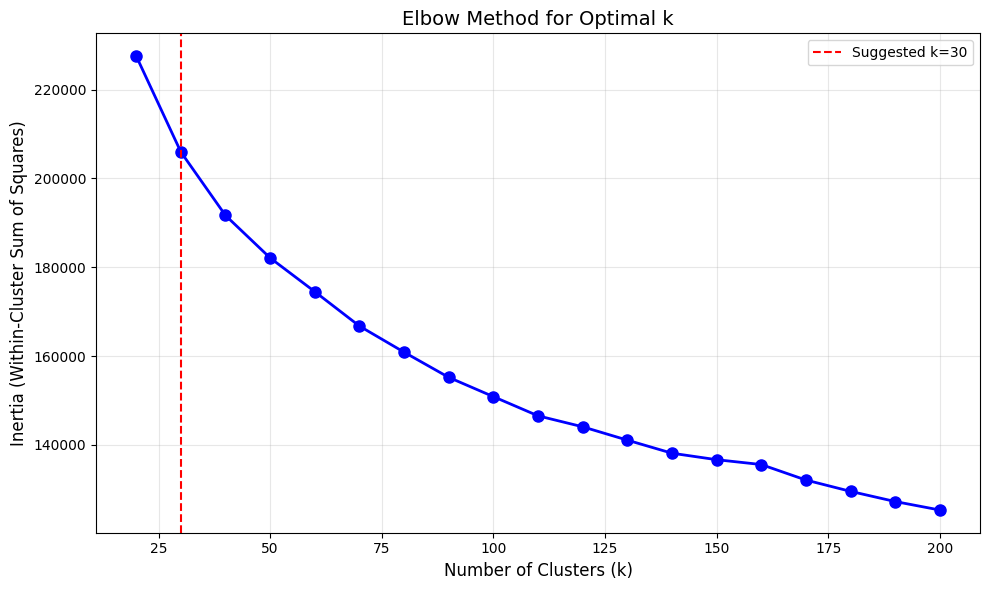


 Suggested k from elbow method: 30


In [20]:
import warnings
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters_elbow(feature_df_indexed, k_range):
    game_matrix = feature_df_indexed.values
    
    inertias = []
    k_values = list(k_range)
    
    print("Testing different numbers of clusters...")
    for k in k_values:
        print(f"  Testing k={k}...", end=" ")
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
        
            kmeans = MiniBatchKMeans(
                n_clusters=k,
                random_state=42,
                batch_size=1000,
                max_iter=100
            )
            kmeans.fit(game_matrix)
            inertias.append(kmeans.inertia_)
            print(f"Inertia: {kmeans.inertia_:.2f}")
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
    plt.title('Elbow Method for Optimal k', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Mark the potential elbow point
    # Simple heuristic: find where rate of decrease slows
    differences = np.diff(inertias)
    second_diff = np.diff(differences)
    elbow_idx = np.argmax(second_diff) + 1
    elbow_k = k_values[elbow_idx]
    
    plt.axvline(x=elbow_k, color='r', linestyle='--', 
                label=f'Suggested k={elbow_k}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\n Suggested k from elbow method: {elbow_k}")
    
    return {
        'k_values': k_values,
        'inertias': inertias,
        'suggested_k': elbow_k
    }


# Run elbow method
elbow_results = find_optimal_clusters_elbow(
    feature_df_indexed, 
    k_range=range(20, 201, 10)  # Test k=20, 30, 40, ..., 200
)

best_k = elbow_results['suggested_k']

## 6.2 Helper functions + Clustering all the games

cluster_all_games
- With the chosen best_k cluster all games using MiniBatchKMeans.
- Cluster labels are added to the feature dataframe for each game.
- Statistics such as average games per cluster and min/max cluster sizes are printed to ensure the clustering is reasonable.
- Pre-clustering games allows for faster cluster-based recommendations later.

analyze_user_clusters
- For a given user, we determine which clusters their library games belong to.
- The cluster distribution shows the number of games in each cluster.
- Cluster weights are computed by normalizing counts, which reflect the user’s relative preference for each cluster.
- These weights will be used to guide cluster-aware recommendations, prioritizing clusters where the user has more games.

get_top_clusters_for_users
- Selects the user’s top clusters based on how many items (e.g., games) they have in each cluster.
- Handles cases with ties or when the user has fewer clusters than requested.
- Returns the selected clusters, their count, and their corresponding weight distribution.

In [21]:
# Pre-cluster all games (done once)
def cluster_all_games(feature_df_indexed, n_clusters):
    print(f"Clustering {len(feature_df_indexed)} games into {n_clusters} clusters...")
    
    game_matrix = feature_df_indexed.values
    
    # Use MiniBatchKMeans for efficiency with large datasets
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        clusterer = MiniBatchKMeans(
            n_clusters=n_clusters, 
            random_state=42,
            batch_size=1000,
            max_iter=100
        )
    
        cluster_labels = clusterer.fit_predict(game_matrix)
    
    # Add cluster labels to dataframe
    feature_df_indexed['cluster'] = cluster_labels
    
    # Print cluster statistics
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print(f"Clustering complete!")
    print(f"Average games per cluster: {cluster_counts.mean():.0f}")
    print(f"Min/Max games per cluster: {cluster_counts.min()}/{cluster_counts.max()}")
    
    return cluster_labels, clusterer


def analyze_user_clusters(user_library, feature_df_indexed, verbose=True):
    user_games_df = feature_df_indexed.loc[
        feature_df_indexed.index.isin(user_library)
    ]
    
    if 'cluster' not in user_games_df.columns:
        raise ValueError("Games must be clustered first. Run cluster_all_games().")
    
    cluster_counts = user_games_df['cluster'].value_counts()
    cluster_weights = cluster_counts / cluster_counts.sum()
    
    if verbose:
        print(f"\nUser's cluster distribution:")
        print(f"User owns games from {len(cluster_counts)} different clusters")
        for cluster_id, weight in cluster_weights.head(5).items():
            count = cluster_counts[cluster_id]
            print(f"  Cluster {cluster_id}: {count} games ({weight*100:.1f}%)")
    
    return {
        'cluster_counts': cluster_counts,
        'cluster_weights': cluster_weights,
        'top_clusters': cluster_counts.index.tolist()
    }

def get_top_clusters_for_user(user_cluster_info, top_n_clusters, verbose=True):
    
    cluster_counts = user_cluster_info['cluster_counts']
    total_clusters_user_has = len(user_cluster_info['top_clusters'])
    
    # Handle case where user has fewer clusters than requested
    if total_clusters_user_has < top_n_clusters:
        n_clusters_to_use = total_clusters_user_has
        top_clusters_to_use = user_cluster_info['top_clusters']
    else:
        # Handle ties: include all clusters with count >= nth highest count
        nth_count = cluster_counts.iloc[top_n_clusters - 1]
        tied_clusters = cluster_counts[cluster_counts >= nth_count].index.tolist()
        n_clusters_to_use = len(tied_clusters)
        top_clusters_to_use = tied_clusters
    
    if verbose:
        print(f"\nUser has {total_clusters_user_has} clusters. Using top {n_clusters_to_use} cluster(s).")
        print(f"Cluster breakdown:")
        for cluster_id in top_clusters_to_use:
            count = cluster_counts[cluster_id]
            weight = user_cluster_info['cluster_weights'][cluster_id]
            print(f"  Cluster {cluster_id}: {count} games ({weight*100:.1f}%)")
    
    return {
        'clusters_to_use': top_clusters_to_use,
        'n_clusters': n_clusters_to_use,
        'cluster_weights': user_cluster_info['cluster_weights']
    }

In [22]:
# Cluster all games (done once)
cluster_labels, clusterer = cluster_all_games(feature_df_indexed, n_clusters=best_k)


Clustering 98248 games into 30 clusters...
Clustering complete!
Average games per cluster: 3275
Min/Max games per cluster: 296/9224


In [ ]:
# Export feature dataframe with clusters
feature_df_indexed.to_csv('game_features_and_clusters.csv', index=True)

## 6.3 Recommend Games By Clusters
- Recommend top 2 games per top 3 clusters that the user has games in.

In [23]:
def recommend_games_clustered_top_per_cluster(
    playerid, 
    feature_df_indexed, 
    purchase_df, 
    games_price_sentiment_df, 
    top_clusters_n, 
    top_games_per_cluster_m,
    verbose=True
):
    """
    Recommend games using cluster-based filtering.
    """
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"CLUSTER-BASED RECOMMENDATIONS FOR PLAYER {playerid}")
        print(f"{'='*60}")

    # Get user library
    user_library = sorted(get_player_library(playerid, purchase_df))

    # Analyze user's cluster preferences
    user_cluster_info = analyze_user_clusters(user_library, feature_df_indexed, verbose=verbose)
    
    # Determine which clusters to use (handles ties automatically)
    cluster_selection = get_top_clusters_for_user(
        user_cluster_info, 
        top_clusters_n, 
        verbose=verbose
    )
    
    # Extract cluster information
    top_clusters_to_use = cluster_selection['clusters_to_use']
    n_clusters_to_use = cluster_selection['n_clusters']

    # Get all unseen games
    unseen_games = sorted(get_unseen_games(user_library, games_price_sentiment_df, verbose=verbose))

    # Filter candidates to games in selected clusters
    candidate_mask = (
        feature_df_indexed.index.isin(unseen_games)
        & feature_df_indexed['cluster'].isin(top_clusters_to_use)
    )
    candidates_df = feature_df_indexed[candidate_mask].copy()

    # Store cluster assignments before getting vectors
    candidate_gameids_all = candidates_df.index.tolist()
    candidate_clusters = candidates_df['cluster'].values

    # Get feature vectors (without cluster column)
    library_vectors, library_gameids = get_game_vectors_with_ids(
        user_library, 
        feature_df_indexed.drop('cluster', axis=1)
    )
    
    candidate_vectors, candidate_gameids = get_game_vectors_with_ids(
        candidate_gameids_all,
        feature_df_indexed.drop('cluster', axis=1)
    )

    # Normalize vectors
    library_vectors = normalize(library_vectors, norm='l2')
    candidate_vectors = normalize(candidate_vectors, norm='l2')

    # Compute similarities
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        sim_matrix = cosine_similarity(candidate_vectors, library_vectors)
        sim_matrix = np.round(sim_matrix, 6)

    avg_similarities = np.nan_to_num(sim_matrix.mean(axis=1), nan=0.0)

    # Build recommendations DataFrame
    recs = pd.DataFrame({
        'gameid': candidate_gameids,
        'similarity_score': avg_similarities,
        'cluster': candidate_clusters,
    }).merge(
        games_price_sentiment_df[['gameid', 'title']], 
        on='gameid', how='left'
    )

    # Get top M games per cluster
    top_recs_list = []
    for cluster_id in top_clusters_to_use:
        cluster_recs = (
            recs[recs['cluster'] == cluster_id]
            .sort_values(by='similarity_score', ascending=False)
            .head(top_games_per_cluster_m)
        )
        top_recs_list.append(cluster_recs)

    top_recs = pd.concat(top_recs_list).reset_index(drop=True)

    if verbose:
        print(f"\n{'='*60}")
        print(f"TOP {top_games_per_cluster_m} RECOMMENDATIONS PER TOP {n_clusters_to_use} CLUSTERS")
        print(f"{'='*60}")
        print(top_recs[['gameid', 'title', 'similarity_score', 'cluster']])

    return top_recs

In [24]:
# Example usage
top_recs = recommend_games_clustered_top_per_cluster(
    playerid=76561198287452552,
    feature_df_indexed=feature_df_indexed,
    purchase_df=purchase_df,
    games_price_sentiment_df=games_price_sentiment_df,
    top_clusters_n=3,
    top_games_per_cluster_m=2
)   


CLUSTER-BASED RECOMMENDATIONS FOR PLAYER 76561198287452552

User's cluster distribution:
User owns games from 16 different clusters
  Cluster 12: 170 games (38.9%)
  Cluster 14: 168 games (38.4%)
  Cluster 5: 26 games (5.9%)
  Cluster 9: 24 games (5.5%)
  Cluster 10: 17 games (3.9%)

User has 16 clusters. Using top 3 cluster(s).
Cluster breakdown:
  Cluster 12: 170 games (38.9%)
  Cluster 14: 168 games (38.4%)
  Cluster 5: 26 games (5.9%)
Player owns 437 games.
Total available games: 98248.
Games not owned: 97811.

TOP 2 RECOMMENDATIONS PER TOP 3 CLUSTERS
   gameid                            title  similarity_score  cluster
0  394510  HELLDIVERS™ Dive Harder Edition          0.854315       12
1  204100                      Max Payne 3          0.854282       12
2  311690                Enter the Gungeon          0.844680       14
3  304430                           INSIDE          0.843690       14
4  885150        Capcom Beat 'Em Up Bundle          0.829523        5
5  761600        

# 7. Export recommendations for all relevant players

In [25]:
from tqdm import tqdm

def generate_recommendations_for_all_players(
    purchase_df, 
    feature_df_indexed, 
    games_price_sentiment_df,
    top_clusters_n=3,
    top_games_per_cluster_m=2,
    save_to_csv=True,
    output_file='recommendations_for_all_players.csv'
):
    
    # Get all unique players
    all_players = purchase_df['playerid'].unique()
    
    all_recommendations = []
    failed_players = []
    
    # Process each player with progress bar
    for playerid in tqdm(all_players, desc="Processing players"):
        try:
            # Generate recommendations for this player
            player_recs = recommend_games_clustered_top_per_cluster(
                playerid=playerid,
                feature_df_indexed=feature_df_indexed,
                purchase_df=purchase_df,
                games_price_sentiment_df=games_price_sentiment_df,
                top_clusters_n=top_clusters_n,
                top_games_per_cluster_m=top_games_per_cluster_m,
                verbose=False  # Suppress individual player output
            )
            
            if player_recs is not None and len(player_recs) > 0:
                # Add playerid to recommendations
                player_recs['playerid'] = playerid
                all_recommendations.append(player_recs)
            else:
                failed_players.append((playerid, "No recommendations generated"))
                
        except Exception as e:
            failed_players.append((playerid, str(e)))
            continue
    
    # Combine all recommendations
    if all_recommendations:
        final_recs = pd.concat(all_recommendations, ignore_index=True)
        
        # Reorder columns
        cols = ['playerid', 'gameid', 'title', 'similarity_score', 'cluster']
        final_recs = final_recs[cols]
        
        print(f"\n{'='*60}")
        print(f"SUMMARY")
        print(f"{'='*60}")
        print(f"Total players processed: {len(all_players)}")
        print(f"Successful recommendations: {len(all_recommendations)}")
        print(f"Failed players: {len(failed_players)}")
        print(f"Total recommendations generated: {len(final_recs)}")
        print(f"Average recommendations per player: {len(final_recs)/len(all_recommendations):.1f}")
        
        if save_to_csv:
            final_recs.to_csv(output_file, index=False)
            print(f"\nRecommendations saved to: {output_file}")
        
        # Show failed players if any
        if failed_players:
            print(f"\nFirst 10 failed players:")
            for playerid, error in failed_players[:10]:
                print(f"  Player {playerid}: {error}")
        
        return final_recs
    else:
        print("\nNo recommendations were generated for any player.")
        return None

In [26]:
all_recommendations = generate_recommendations_for_all_players(
    purchase_df=purchase_df,
    feature_df_indexed=feature_df_indexed,
    games_price_sentiment_df=games_price_sentiment_df,
    top_clusters_n=3,
    top_games_per_cluster_m=2,
    save_to_csv=True,
    output_file='recommendations_for_all_players.csv'
)

all_recommendations.head()

Processing players: 100%|██████████| 46932/46932 [20:37:40<00:00,  1.58s/it]      



SUMMARY
Total players processed: 46932
Successful recommendations: 46932
Failed players: 0
Total recommendations generated: 289102
Average recommendations per player: 6.2

Recommendations saved to: recommendations_for_all_players.csv


,playerid,gameid,title,similarity_score,cluster
0,76561198060698936,239200,Amnesia: A Machine for Pigs,0.714217,12
1,76561198060698936,231160,The Swapper,0.708787,12
2,76561198060698936,365590,Tom Clancy’s The Division™,0.654243,14
3,76561198060698936,285900,Gang Beasts,0.648161,14
4,76561198060698936,481110,The Bunker,0.693390,5
